# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Guangzhou is at the heart of the most-populous built-up metropolitan area in mainland China, which extends into the neighboring cities of Foshan, Dongguan, Zhongshan and Shenzhen, forming one of the largest urban agglomerations on Earth, the Pearl River Delta Economic Zone. Administratively, the city holds sub-provincial status and is one of China's nine National Central Cities. At the end of 2018, the population of the city's expansive administrative area was estimated at 14,904,400 by city authorities, up 3.8% from the previous year. 

I live in Foshan which is near Guangzhou. Nowadays lots of people heading Guangzhou for its rich job opportunities. Guangzhou is split to 11 districts and all of them have their own features. One important question is that if you want to work and live in Guangzhou which districts should you choose. It is may depend on the venues in that area, house prices, population densities and so on. 

So after thinking about this question, I will try to discover the similarities and dissimilarities of the 11 districts in Guangzhou. Also the house prices of each district will be considered too. We will create a map include all the information which helps people easily decide which districts they would choose.


## Data <a name="data"></a>

To consider the question we can list the data below: 
1. I use geopy package in python to find the center coordinate of Guangzhou as well as the center coordinate of 11 districts. 
2. From http://datav.aliyun.com/ I find the geojson file of Guangzhou city which is used to create the choropleth map. 
3. From http://gz.cityhouse.cn/market I find the average house prices of 11 districts of Guangzhou. 
4. I use Forsquare API to get the most common venues of given districts of Guangzhou


## Methodology <a name="methodology"></a>

First we import the required libraries

In [28]:
#import library
#!pip install beautifulsoup4
#!pip install lxml
#!pip install request
#!pip install geocoder
#!pip install folium
import requests
import pandas as pd
import numpy as np
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json
from pandas.io.json import json_normalize
import folium
import matplotlib.pyplot as plt


I use geocoder Nominatim to obtain the exact enter coordinate of Guangzhou as well as its districts. There are 11 districts in Guangzhou: Liwan, Yuexiu, Haizhu, Tianhe, Baiyun, Huangpu, Panyu, Huadu, Nansha, Conghua and Zengcheng. We get all their coordinate and transfer to a dataframe.

In [4]:
address = 'Guangzhou,China'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude

In [5]:
list_gz=['liwan','yuexiu','haizhu','tianhe','baiyun','huangpu','panyu','huadu','nansha','conghua','zengcheng']

In [6]:
lat=[]
lng=[]
for i in list_gz:
    address = '{},Guangzhou,China'.format(i)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    lat.append(location.latitude)
    lng.append(location.longitude)
    

In [7]:
df_gz=pd.DataFrame(data=[list_gz,lat,lng]).T
df_gz.columns=['District','Latitude','Longitude']
df_gz

,District,Latitude,Longitude
0,liwan,23.1286,113.239
1,yuexiu,23.1315,113.261
2,haizhu,23.086,113.312
3,tianhe,23.1271,113.356
4,baiyun,23.1606,113.268
5,huangpu,23.1825,113.476
6,panyu,22.9387,113.379
7,huadu,23.4056,113.215
8,nansha,22.8027,113.52
9,conghua,23.5509,113.58


We can create a map to visualize them

In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_gz['Latitude'], df_gz['Longitude'], df_gz['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Noticed that some of the districts are very close to each other and some are far from the city center.

Next we use Foursquare API to explore the districts and segment them. The limit of venues return is set to 100 since I only get the personal account. And also the radius is set to 2500 meters which means we would like to find the venues which locate within 2500 meters from districts center. After setting all these parameters we get 433 venues of all 11 districts.


In [12]:
CLIENT_ID = 'VCFQR0E1BTCZWQVRND3OYBOZY5FJDY0YT2RN35CRKJKJEQP4' # your Foursquare ID
CLIENT_SECRET = 'FNCWVTOWKKLIHTHLFYKGYQCT5BDFW2BWYSUUY1AMLM0CQULU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VCFQR0E1BTCZWQVRND3OYBOZY5FJDY0YT2RN35CRKJKJEQP4
CLIENT_SECRET:FNCWVTOWKKLIHTHLFYKGYQCT5BDFW2BWYSUUY1AMLM0CQULU


Get venues for 11 districts

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
gz_venues = getNearbyVenues(names=df_gz['District'],
                                   latitudes=df_gz['Latitude'],
                                   longitudes=df_gz['Longitude']
                                  )

liwan
yuexiu
haizhu
tianhe
baiyun
huangpu
panyu
huadu
nansha
conghua
zengcheng


In [14]:
print(gz_venues.shape)
gz_venues.head()

(433, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,liwan,23.128625,113.239199,點都德,23.125928,113.241140,Cantonese Restaurant
1,liwan,23.128625,113.239199,Lizhi Wan (荔枝湾),23.123997,113.232286,Lake
2,liwan,23.128625,113.239199,Guangdong Folk Art Museum (Chen Clan Academy) ...,23.129088,113.240169,Historic Site
3,liwan,23.128625,113.239199,Liu Hua Park (流花湖公园),23.139302,113.246531,Park
4,liwan,23.128625,113.239199,Panxi Restaurant (泮溪酒家),23.123726,113.230310,Cantonese Restaurant


We also group the venues by districts to see how many venues each districts have.

In [15]:
gz_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
baiyun,100,100,100,100,100,100
conghua,7,7,7,7,7,7
haizhu,38,38,38,38,38,38
huadu,6,6,6,6,6,6
huangpu,4,4,4,4,4,4
liwan,100,100,100,100,100,100
nansha,4,4,4,4,4,4
panyu,15,15,15,15,15,15
tianhe,50,50,50,50,50,50


From above Baiyun, Liwan and Yuexiu reach the 100 limit venues. This indicate that these districts are very popular. And if you check out their location you will find they locate in the city center. This explains why they are so popular. On contrary Nansha and Huangpu only receive 4 venues which may due to their large area and not locate in city center.


In [16]:
print('There are {} uniques categories.'.format(len(gz_venues['Venue Category'].unique())))

There are 97 uniques categories.


There are 97 unique venues categories. In order to cluster the districts I created a table which shows list of top 10 venue category for each districts in below table.

In [17]:
# one hot encoding
gz_onehot = pd.get_dummies(gz_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gz_onehot['Neighborhood'] = gz_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [gz_onehot.columns[-1]] + list(gz_onehot.columns[:-1])
gz_onehot = gz_onehot[fixed_columns]

gz_onehot.head()

,Neighborhood,Accessories Store,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Big Box Store,Boarding House,...,Steakhouse,Temple,Thai Restaurant,Toll Booth,Toy / Game Store,Turkish Restaurant,Vietnamese Restaurant,Volcano,Watch Shop,Yoga Studio
0,liwan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,liwan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,liwan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,liwan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,liwan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
gz_grouped = gz_onehot.groupby('Neighborhood').mean().reset_index()
gz_grouped

,Neighborhood,Accessories Store,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Big Box Store,Boarding House,...,Steakhouse,Temple,Thai Restaurant,Toll Booth,Toy / Game Store,Turkish Restaurant,Vietnamese Restaurant,Volcano,Watch Shop,Yoga Studio
0,baiyun,0.02,0.00,0.010000,0.01,0.00,0.00,0.00,0.010000,0.000000,...,0.010000,0.00,0.00,0.000000,0.00,0.03,0.00,0.000000,0.01,0.000000
1,conghua,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000
2,haizhu,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.026316,0.000000,...,0.000000,0.00,0.00,0.026316,0.00,0.00,0.00,0.026316,0.00,0.000000
3,huadu,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000
4,huangpu,0.00,0.00,0.000000,0.00,0.00,0.00,0.25,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000
5,liwan,0.00,0.00,0.020000,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.02,0.000000,0.01,0.01,0.01,0.000000,0.00,0.000000
6,nansha,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000
7,panyu,0.00,0.00,0.066667,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.066667,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.066667
8,tianhe,0.00,0.02,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000
9,yuexiu,0.00,0.00,0.010000,0.01,0.02,0.02,0.00,0.000000,0.000000,...,0.000000,0.01,0.02,0.000000,0.00,0.05,0.02,0.000000,0.00,0.000000


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = gz_grouped['Neighborhood']

for ind in np.arange(gz_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(gz_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.rename(columns={'Neighborhood':'District'},inplace=True)
neighborhoods_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,baiyun,Fast Food Restaurant,Hotel,Coffee Shop,Middle Eastern Restaurant,Pizza Place,Shopping Mall,Café,Clothing Store,Turkish Restaurant,Indian Restaurant
1,conghua,Hotel,Cantonese Restaurant,Fast Food Restaurant,Hotel Pool,Metro Station,Pizza Place,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court
2,haizhu,Fast Food Restaurant,Café,Hotel,Coffee Shop,Shopping Mall,Chinese Restaurant,Park,Italian Restaurant,Metro Station,Miscellaneous Shop
3,huadu,Fast Food Restaurant,Pizza Place,Diner,Coffee Shop,Restaurant,Electronics Store,Fish & Chips Shop,Fish Market,Food Court,French Restaurant
4,huangpu,Shopping Mall,Hotel,Basketball Stadium,Metro Station,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court,French Restaurant,Fried Chicken Joint
5,liwan,Hotel,Fast Food Restaurant,Coffee Shop,Shopping Mall,Cantonese Restaurant,Park,Chinese Restaurant,History Museum,Pizza Place,Sandwich Place
6,nansha,Shopping Mall,Coffee Shop,Hotel,Metro Station,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court,French Restaurant,Fried Chicken Joint
7,panyu,Coffee Shop,Yoga Studio,Bus Station,Hotel,Japanese Restaurant,Metro Station,Food Court,Fast Food Restaurant,Plaza,Cantonese Restaurant
8,tianhe,Fast Food Restaurant,Coffee Shop,Hotel,Café,Chinese Restaurant,Pizza Place,Sandwich Place,Park,German Restaurant,Grocery Store
9,yuexiu,Hotel,Coffee Shop,Shopping Mall,Turkish Restaurant,Park,Chinese Restaurant,Middle Eastern Restaurant,Cantonese Restaurant,Fast Food Restaurant,Sandwich Place


And then we use K-means to cluster districts. First I want to find the optimize K 

In [21]:
from sklearn.cluster import KMeans

In [22]:
gz_grouped_clustering = gz_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(gz_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

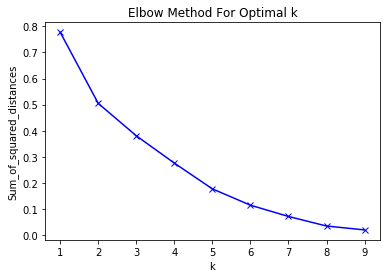

In [23]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

I use elbow method to plot and find the best k to be 2, then we can do cluster

In [24]:
# set number of clusters
kclusters = 2



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gz_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0], dtype=int32)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

gz_merged = df_gz

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
gz_merged = gz_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')
gz_merged

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,liwan,23.1286,113.239,0,Hotel,Fast Food Restaurant,Coffee Shop,Shopping Mall,Cantonese Restaurant,Park,Chinese Restaurant,History Museum,Pizza Place,Sandwich Place
1,yuexiu,23.1315,113.261,0,Hotel,Coffee Shop,Shopping Mall,Turkish Restaurant,Park,Chinese Restaurant,Middle Eastern Restaurant,Cantonese Restaurant,Fast Food Restaurant,Sandwich Place
2,haizhu,23.086,113.312,0,Fast Food Restaurant,Café,Hotel,Coffee Shop,Shopping Mall,Chinese Restaurant,Park,Italian Restaurant,Metro Station,Miscellaneous Shop
3,tianhe,23.1271,113.356,0,Fast Food Restaurant,Coffee Shop,Hotel,Café,Chinese Restaurant,Pizza Place,Sandwich Place,Park,German Restaurant,Grocery Store
4,baiyun,23.1606,113.268,0,Fast Food Restaurant,Hotel,Coffee Shop,Middle Eastern Restaurant,Pizza Place,Shopping Mall,Café,Clothing Store,Turkish Restaurant,Indian Restaurant
5,huangpu,23.1825,113.476,1,Shopping Mall,Hotel,Basketball Stadium,Metro Station,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court,French Restaurant,Fried Chicken Joint
6,panyu,22.9387,113.379,0,Coffee Shop,Yoga Studio,Bus Station,Hotel,Japanese Restaurant,Metro Station,Food Court,Fast Food Restaurant,Plaza,Cantonese Restaurant
7,huadu,23.4056,113.215,0,Fast Food Restaurant,Pizza Place,Diner,Coffee Shop,Restaurant,Electronics Store,Fish & Chips Shop,Fish Market,Food Court,French Restaurant
8,nansha,22.8027,113.52,1,Shopping Mall,Coffee Shop,Hotel,Metro Station,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court,French Restaurant,Fried Chicken Joint
9,conghua,23.5509,113.58,0,Hotel,Cantonese Restaurant,Fast Food Restaurant,Hotel Pool,Metro Station,Pizza Place,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court


In [26]:
gz_merged.loc[gz_merged['Cluster Labels'] == 0, gz_merged.columns[[0] + list(range(4, gz_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,liwan,Hotel,Fast Food Restaurant,Coffee Shop,Shopping Mall,Cantonese Restaurant,Park,Chinese Restaurant,History Museum,Pizza Place,Sandwich Place
1,yuexiu,Hotel,Coffee Shop,Shopping Mall,Turkish Restaurant,Park,Chinese Restaurant,Middle Eastern Restaurant,Cantonese Restaurant,Fast Food Restaurant,Sandwich Place
2,haizhu,Fast Food Restaurant,Café,Hotel,Coffee Shop,Shopping Mall,Chinese Restaurant,Park,Italian Restaurant,Metro Station,Miscellaneous Shop
3,tianhe,Fast Food Restaurant,Coffee Shop,Hotel,Café,Chinese Restaurant,Pizza Place,Sandwich Place,Park,German Restaurant,Grocery Store
4,baiyun,Fast Food Restaurant,Hotel,Coffee Shop,Middle Eastern Restaurant,Pizza Place,Shopping Mall,Café,Clothing Store,Turkish Restaurant,Indian Restaurant
6,panyu,Coffee Shop,Yoga Studio,Bus Station,Hotel,Japanese Restaurant,Metro Station,Food Court,Fast Food Restaurant,Plaza,Cantonese Restaurant
7,huadu,Fast Food Restaurant,Pizza Place,Diner,Coffee Shop,Restaurant,Electronics Store,Fish & Chips Shop,Fish Market,Food Court,French Restaurant
9,conghua,Hotel,Cantonese Restaurant,Fast Food Restaurant,Hotel Pool,Metro Station,Pizza Place,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court


In [27]:
gz_merged.loc[gz_merged['Cluster Labels'] == 1, gz_merged.columns[[0] + list(range(4, gz_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,huangpu,Shopping Mall,Hotel,Basketball Stadium,Metro Station,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court,French Restaurant,Fried Chicken Joint
8,nansha,Shopping Mall,Coffee Shop,Hotel,Metro Station,Yoga Studio,Fish & Chips Shop,Fish Market,Food Court,French Restaurant,Fried Chicken Joint
10,zengcheng,Coffee Shop,Shopping Mall,Hunan Restaurant,Garden,Boarding House,Metro Station,Clothing Store,Yoga Studio,Gym / Fitness Center,Fish Market


After running the K-means algorithms we can see the result.Huangpu, Nansha, Zengcheng are classify to one cluster while all the other 9 districts are cluster to cluster 1. Looking at the 1st most common venue we can label the cluster as:

Cluster 1: “Hotel, fast food and coffee shop venues”

Cluster 2: ”Shopping mall and coffee shop venues”

We can then visualize the cluster on map:


In [238]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [239]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(gz_merged['Latitude'], gz_merged['Longitude'], gz_merged['District'], gz_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Also we want to construct the choropleth map so I download the average house price data from the Internet and combine them with the district names. The price unit is yuan/m2. We also download the geojson file.

In [38]:
!wget --quiet https://geo.datav.aliyun.com/areas_v2/bound/440100_full.json

In [114]:
price=[34126,51801,42024,51789,31180,24689,27830,15443,20299,14285,16957]

In [115]:
import geojson
from geojson import Feature, FeatureCollection, Polygon
import numpy as np

with open('440100_full.json', 'rb') as f:
    districts = geojson.load(f) 
features = [] 
color = [] 
for idx, geometry in enumerate(districts['features']): 
    
    circle = geometry['geometry']['coordinates'][0][0]
    color.append([str(idx)]) 
    polygon = Polygon([circle]) 
    features.append(Feature(
        id=str(idx), 
        geometry=polygon 
    ))
feature_collection = FeatureCollection(features) 


In [116]:
df_price=pd.DataFrame(color, columns=['idx'])
df_price['price']=price
df_price['name']=list_gz
df_price

,idx,price,name
0,0,34126,liwan
1,1,51801,yuexiu
2,2,42024,haizhu
3,3,51789,tianhe
4,4,31180,baiyun
5,5,24689,huangpu
6,6,27830,panyu
7,7,15443,huadu
8,8,20299,nansha
9,9,14285,conghua


In [240]:
# create map and display it
gz_map = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Choropleth(
    geo_data=feature_collection, 
    name='choropleth',
    data=df_price, 
    columns=['idx','price'], 
    key_on='feature.id', 
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,  
    legend_name='Rank' 
).add_to(gz_map)
for lat, lon, poi, cluster in zip(gz_merged['Latitude'], gz_merged['Longitude'], gz_merged['District'], gz_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(gz_map)
gz_map

## Results and Discussion <a name="results"></a>

After doing all this job we can easily visualize the feature of each districts in Guangzhou. It seems that the districts located in city center such as Tianhe have very high house prices, if we want to live in there we would probably cannot afford. But after cluster the districts we find that some districts such as Huadu shares the same venues categories with Tianhe. So in this case if you want to enjoy the city center’s rich venues but cannot afford the high house price, why not choose to live in Huadu where the house price is lower. So from the result someone may get what they want. But also there are some limitations of the analysis. Since the area of each districts are different and we choose their center coordinate, we cannot guarantee that the venues densities are the same within each district. We can repeat this analysis by changing the coordinate to what we want to get specific result. 

## Conclusion <a name="conclusion"></a>

As a result, more and more people are heading to their ideal cities for working and living. So it might be very helpful to analyze the city before you go and determine where do you want to stay. For those investor this kind of analysis is very helpful too.

Hope we all have a good future!
